In [5]:
import os, glob, subprocess, datetime

import pandas as pd
import geopandas as gpd
import numpy as np
import pickle as pkl
import scipy.stats as stats
import properscoring as ps
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scores import *
from matplotlib_scalebar.scalebar import ScaleBar
from sklearn.neighbors import KernelDensity
from scipy.integrate import quad
from scipy import interpolate
from ipywidgets import *
from sklearn.linear_model import BayesianRidge, LinearRegression
from scipy.stats import multivariate_normal, norm
from scipy.interpolate import make_smoothing_spline

plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125
plt.rcParams['font.family']         = 'Avenir'

path_to_fPCA   = '/Users/Guille/Desktop/dynamic_update/software/fPCA'
path_to_fDepth = '/Users/Guille/Desktop/dynamic_update/software/fDepth'
path_to_data   = '/Users/Guille/Desktop/dynamic_update/data'
path_to_images = '/Users/Guille/Desktop/dynamic_update/images'

In [6]:
meta_ = pd.read_excel(path_to_data + '/wind_meta.xlsx')
meta_ = meta_.rename(columns = {'lati': 'lat', 
                                'longi': 'log', 
                                'Facility.Name': 'name', 
                                'Capacity': 'capacity'})
meta_ = meta_[['name', 'log', 'lat', 'capacity']]

In [7]:
TX_    = gpd.read_file(path_to_data + '/maps/TX/State.shp')
ERCOT_ = gpd.read_file(path_to_data + '/maps/ERCOT/eia-mod-BW-ERCOT-shapefile.shp')

26.1186 36.4978
-104.742 -95.4551


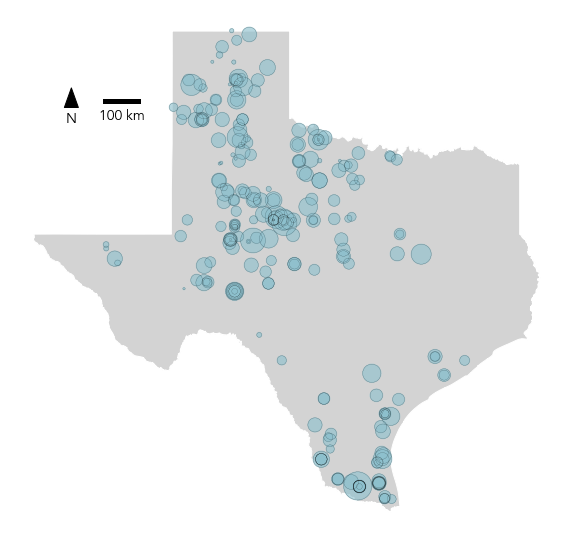

In [8]:
fig, ax = plt.subplots(figsize = (10, 10))  # Adjust figure size as needed


TX_.plot(ax        = ax, 
         facecolor = 'lightgray', 
         edgecolor = 'white')

scale = 1.5
ax.scatter(meta_['log'], meta_['lat'], s     = meta_['capacity']/scale, 
                                       c     = '#8dc0cd', 
                                       alpha = 0.625)

ax.scatter(meta_['log'], meta_['lat'], s         = meta_['capacity']/scale,
                                       edgecolor = 'k', 
                                       lw        = .125, 
                                       facecolor = 'None')

print(meta_['lat'].min(), meta_['lat'].max())
print(meta_['log'].min(), meta_['log'].max())

# Add compass (North arrow)
x, y, arrow_length = 0.115, 0.85, .0625  # relative axes coords
ax.annotate('N', xy         = (x, y), 
                 xytext     = (x, y - arrow_length),
                 arrowprops = dict(facecolor='k', arrowstyle = 'wedge,tail_width=1,shrink_factor=.5' ),
                 ha         = 'center', 
                 va         = 'center',
                 fontsize   = 14,
                 xycoords   = ax.transAxes)

scalebar = ScaleBar(dx              = 100,  # scaling factor
                    units           = 'km', 
                    dimension       = 'si-length',  # could also be 'imperial-length'
                    location        = 'upper left',
                    length_fraction = .075,  # fraction of the axis for bar length
                    color           = 'black',
                    box_color       = 'None',
                    box_alpha       = 1.,
                    border_pad      = 9,
                    font_properties = {'size': 14})

ax.add_artist(scalebar)

ax.set_axis_off()

plt.show()

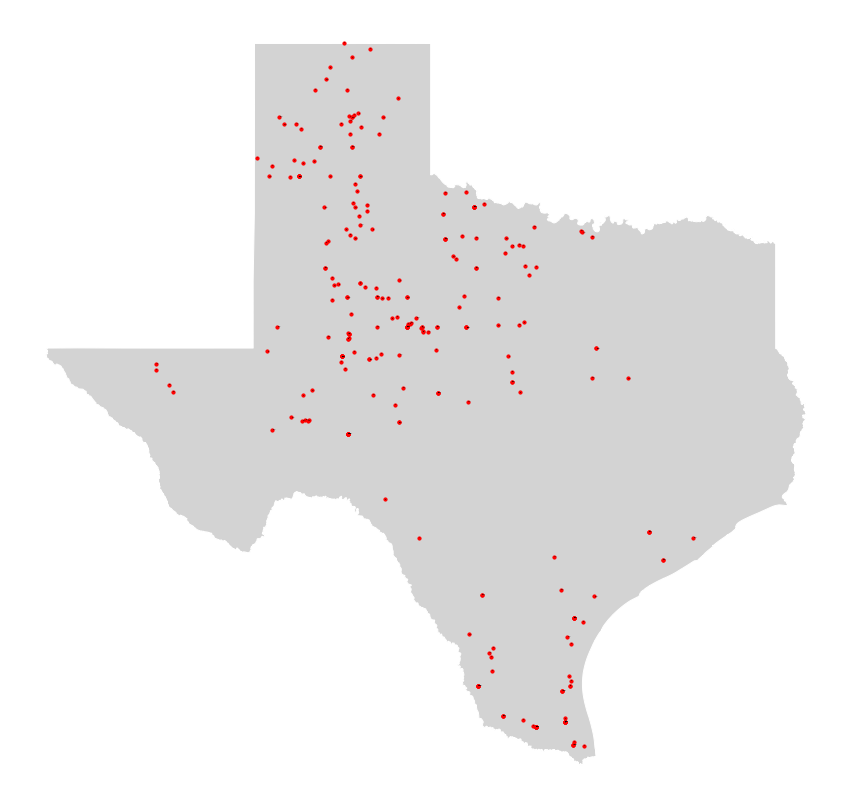

In [23]:
# Dense: 48, 87, 109, 110, 115
# Sparse: 1, 91, 248, 158, 116


fig, ax = plt.subplots(figsize = (15, 15))  # Adjust figure size as needed

TX_.plot(ax        = ax, 
         facecolor = 'lightgray', 
         edgecolor = 'white')

for i in range(meta_.shape[0]):
    ax.scatter(meta_.loc[i, 'log'], meta_.loc[i, 'lat'], s = 10., c = 'r')

    ax.annotate(i, (meta_.loc[i, 'log'], meta_.loc[i, 'lat']), size = 2)

ax.set_axis_off()

plt.savefig(path_to_images + r'/index_map.pdf', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

In [112]:
def _predictive_intervals(f_ts_hat_, S_ts_hat_, z = 1.6, f_min = 0, f_max = 1):
    
    s_ts_hat_  = np.sqrt(np.diagonal(S_ts_hat_))
    f_ts_upper = f_ts_hat_ + z*s_ts_hat_
    f_ts_lower = f_ts_hat_ - z*s_ts_hat_
    
    f_ts_lower = _gen_constraint(f_ts_lower, f_min, f_max)
    f_ts_upper = _gen_constraint(f_ts_upper, f_min, f_max)

    return f_ts_upper, f_ts_lower

def _plot_results(F_tr_, S_ts_hat_, f_ts_hat_, f_tr_, f_ts_, t_tr_, t_ts_, dates_, i_day, t_event):
    

    plt.figure(figsize = (10, 2.5))
    plt.title('{}'.format(dates_[i_day, t_event]))

    f_ts_lower, f_ts_upper = _predictive_intervals(f_ts_hat_, S_ts_hat_, z = 2.25, f_min = F_tr_.min(), f_max = F_tr_.max())
    plt.fill_between(t_ts_, f_ts_lower, f_ts_upper, color = 'gray', alpha = .1, label = '97.5% (ci)')
    f_ts_lower, f_ts_upper = _predictive_intervals(f_ts_hat_, S_ts_hat_, z = 1.96, f_min = F_tr_.min(), f_max = F_tr_.max())
    plt.fill_between(t_ts_, f_ts_lower, f_ts_upper, color = 'gray', alpha = .15, label = '95% (ci)')
    f_ts_lower, f_ts_upper = _predictive_intervals(f_ts_hat_, S_ts_hat_, z = 1.65, f_min = F_tr_.min(), f_max = F_tr_.max())
    plt.fill_between(t_ts_, f_ts_lower, f_ts_upper, color = 'gray', alpha = .2, label = '90% (ci)')
    f_ts_lower, f_ts_upper = _predictive_intervals(f_ts_hat_, S_ts_hat_, z = 1.28, f_min = F_tr_.min(), f_max = F_tr_.max())
    plt.fill_between(t_ts_, f_ts_lower, f_ts_upper, color = 'gray', alpha = .25, label = '80% (ci)')
    f_ts_lower, f_ts_upper = _predictive_intervals(f_ts_hat_, S_ts_hat_, z = 0.84, f_min = F_tr_.min(), f_max = F_tr_.max())
    plt.fill_between(t_ts_, f_ts_lower, f_ts_upper, color = 'gray', alpha = .3, label = '60% (ci)')

    plt.plot(t_tr_, f_tr_, c = 'k', label = 'ac (obv)')
    plt.plot(t_ts_, f_ts_, c = 'red', label = 'ac (unobv)')
    plt.plot(t_ts_, f_ts_hat_, color = 'green', label = 'fc (update)')
    
    plt.axvline(t_ts_[0], lw = 2, c = 'lime', label = 'event')

    # plt.ylim(F_tr_.min(), F_tr_.max())
    # plt.xlim(0, 287)
    #plt.legend(frameon = False, ncol = 6)
    plt.xticks(np.concatenate([t_tr_, t_ts_], axis = 0)[::12], 
                              [datetime.datetime.fromisoformat(date).strftime('%H:%M') for date in dates_[i_day, ::12]], rotation = 45)

    plt.show()

[8, 1] [4, 16, 1]
8
(16104,)
(16104,)
(16104,)
(16104,)
(16104,)
(16104,)
(16104,)
(16104,)


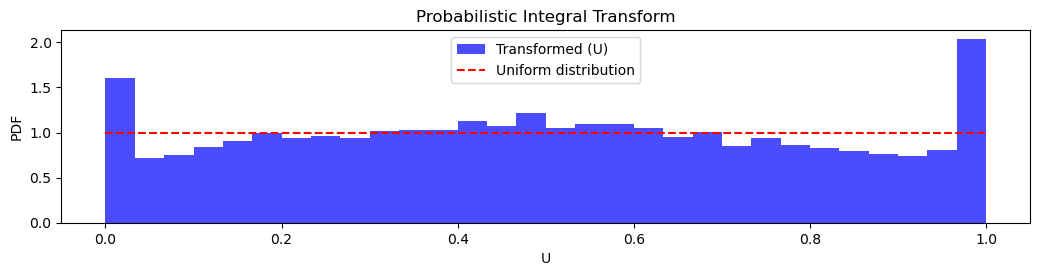

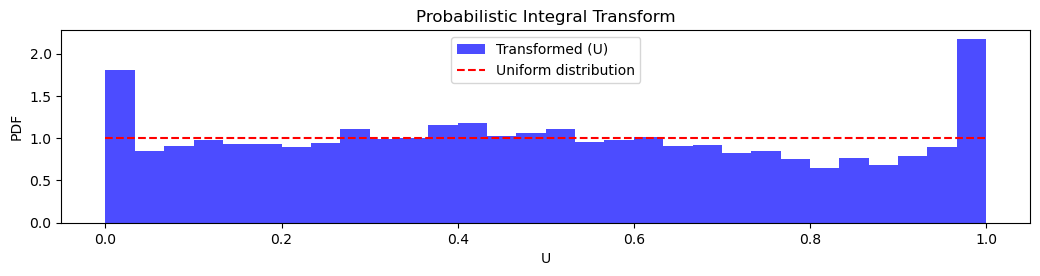

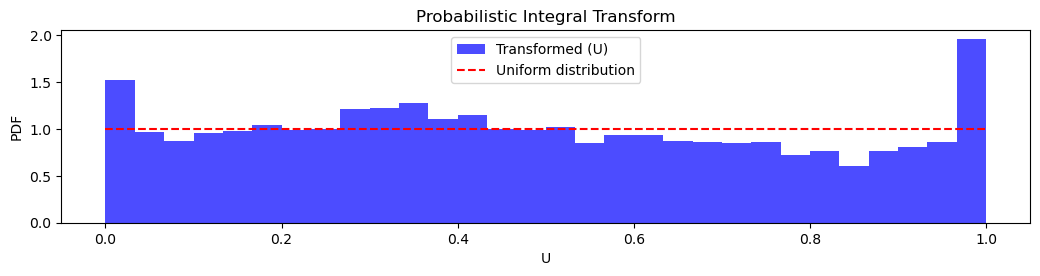

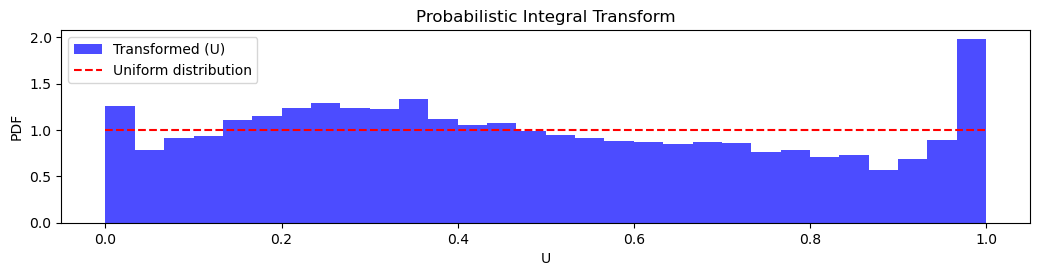

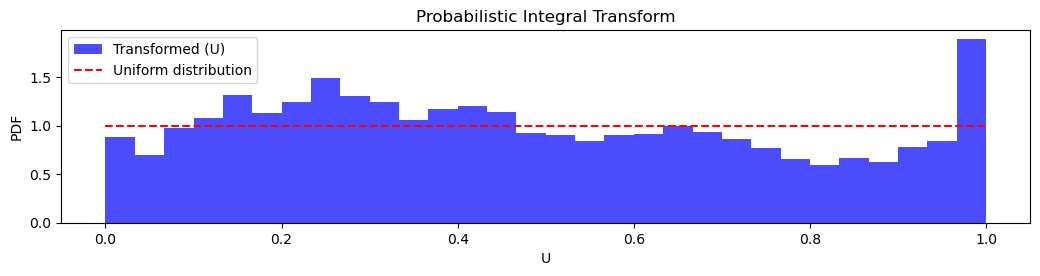

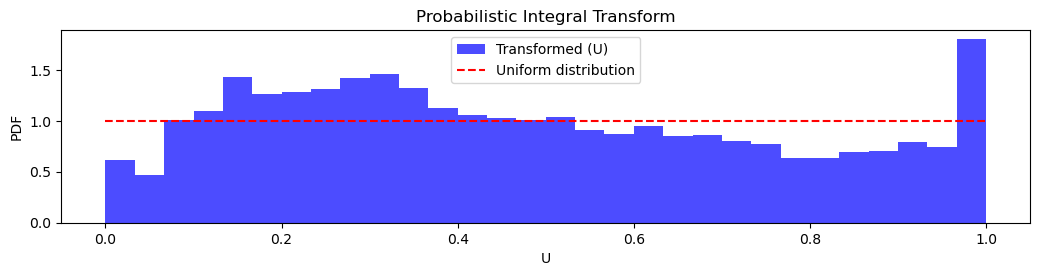

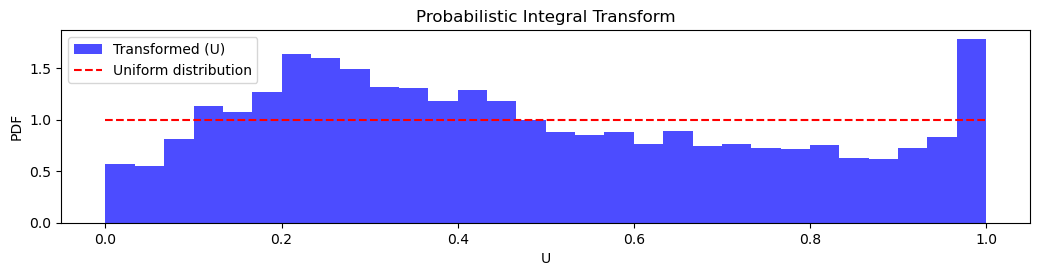

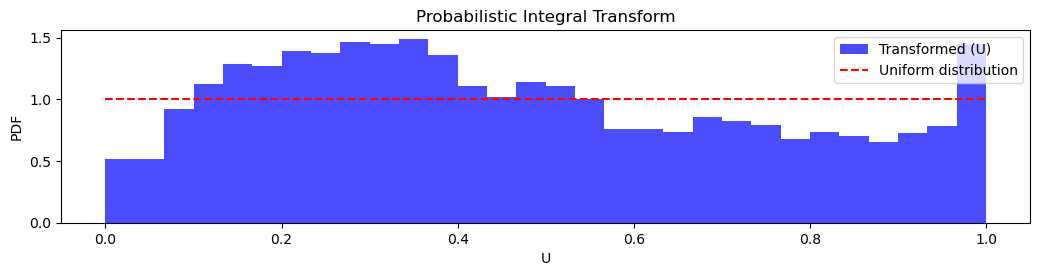

In [119]:
def _exp(ac_tr_, ac_ts_, date_ts_, interval_, horizon_, params_, verbose = True):
    
    if verbose: print(horizon_, interval_)
    
    f_ts_hat_all_ = [[] for horizon in range(horizon_[0])]
    s_ts_hat_all_ = [[] for horizon in range(horizon_[0])]
    f_ts_all_     = [[] for horizon in range(horizon_[0])]

    for yearday in range(ac_ts_.shape[0]):
        for interval in range(interval_[0], interval_[1], interval_[2]):
            interval *= 12
            F_tr_, F_ts_, f_tr_, f_ts_, t_tr_, t_ts_ = _test_fc(ac_tr_, ac_ts_, date_ts_,
                                                                i_day   = yearday, 
                                                                t_event = interval,
                                                                viz     = False)

            idx_1_ = f_ts_ <= F_tr_.min()
            idx_2_ = f_ts_ >= F_tr_.max()
        
            if (idx_1_.sum() + idx_2_.sum()) == 0.:
                f_ts_hat_, S_ts_hat_, F_ts_scen_ = _fknn_fc(F_tr_, f_tr_, F_ts_,
                                                            forget_rate  = params_['forget_rate'], 
                                                            prob         = params_['prob'],
                                                            k            = params_['k'],
                                                            length_scale = params_['length_scale'],
                                                            smoothing    = params_['smoothing'],
                                                            lamdba       = params_['lamdba'],
                                                            viz          = False)

                # _plot_results(F_tr_, 
                #               S_ts_hat_, 
                #               f_ts_hat_, 
                #               f_tr_,
                #               f_ts_, 
                #               t_tr_, t_ts_, date_ts_, yearday, interval)
                s_ts_hat_ = np.sqrt(np.diagonal(S_ts_hat_))
                # idx_ = s_ts_hat_ == 0.
                # if idx_.sum() > 0.:
                #     print(yearday)
                for horizon in range(horizon_[0]):
                    h0  = horizon
                    h0 *= 12
                    h0 *= horizon_[1]

                    h1  = horizon + 1
                    h1 *= 12
                    h1 *= horizon_[1]

                    if h1 > s_ts_hat_.shape[0]:
                        continue
                    else:
                        f_ts_hat_all_[horizon].append(f_ts_hat_[h0:h1])
                        s_ts_hat_all_[horizon].append(s_ts_hat_[h0:h1])
                        f_ts_all_[horizon].append(f_ts_[h0:h1])

    f_ts_hat_ = [np.concatenate(f_ts_hat_all_[horizon], axis = 0) for horizon in range(horizon_[0])]
    s_ts_hat_ = [np.concatenate(s_ts_hat_all_[horizon], axis = 0) for horizon in range(horizon_[0])]
    f_ts_     = [np.concatenate(f_ts_all_[horizon], axis = 0) for horizon in range(horizon_[0])]
    return f_ts_, f_ts_hat_, s_ts_hat_


def _PIT(y_true, forecast_mean, forecast_std, nbins = 30):
    """
    Calculate the Probabilistic Integral Transform (PIT).
    
    Parameters:
    - y_true: Observed (true) values
    - forecast_mean: Mean of the predicted distribution (e.g., mean of the normal distribution)
    - forecast_std: Standard deviation of the predicted distribution
    
    Returns:
    - mean and std: The calculated PIT
    """
            
    u_samples = norm.cdf(y_true, loc = forecast_mean, scale = forecast_std)
    
    # Plot the histogram of U to check if it's uniformly distributed
    plt.figure(figsize = (12.5, 2.5))
    plt.hist(u_samples, bins    = nbins, 
                        density = True, 
                        alpha   = 0.7, 
                        color   = 'blue', 
                        label   = 'Transformed (U)')
    
    plt.hlines(1, 0, 1, color     = 'red', 
                        linestyle = '--', 
                        label     = 'Uniform distribution')
    
    plt.title('Probabilistic Integral Transform')
    plt.xlabel('U')
    plt.ylabel('PDF')
    plt.legend()

    
params_ = {'method': 'fknn_fc',
           'forget_rate':  1,
           'length_scale': 10,
           'k':            250,
           'prob':         0.9,
           'smoothing':      0,
           'lamdba':         0}

horizon_  = [8, 1]
interval_ = [4, 16, 1]

f_ts_, f_ts_hat_, s_ts_hat_ = _exp(ac_tr_, ac_ts_, date_ts_, interval_, horizon_, params_)
print(len(f_ts_))
for horion in range(len(f_ts_)):
    print(f_ts_[horion].shape)
    _PIT(f_ts_[horion], f_ts_hat_[horion], s_ts_hat_[horion])
